In [4]:
import os
import ast
import re
from datetime import datetime

import dimcli
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import matplotlib.ticker as mticker

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, PercentFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import ast
import re

from helpers_scrape import (login_dimcli,
                            get_dataset_pubs,
                            get_dataset,
                            merger)

In [5]:
timestamp = datetime.now().strftime("%Y%m")

dsl = login_dimcli()

Dimcli - Dimensions API Client (v1.4)
Connected to: <https://app.dimensions.ai/api/dsl/v2> - DSL v2.13
Method: manual login


In [6]:
# Dictionary of biobank names with their alternate appellations.
BB_dict = {
    'UKBB': ['\"UK Biobank\"', '\"UK Bio Bank\"', '\"United Kingdom Biobank\"'],
    'CKBB': ['\"Kadoorie Biobank\"', '\"Kadoorie Bio Bank\"', '\"Kadoorie Study\"', '\"Kadoorie Survey\"'],
    'EBB': ['\"Estonian Biobank\"', '\"Estonian Genome Center Biobank\"', '\"Biobank of Estonia\"'],
    'ELSA': ['\"English Longitudinal Study of Ageing\"', '\"ELSA Cohort\"', '\"ELSA Study\"', '\"ELSA Survey\"'],
    'BBJ': ['\"Biobank Japan\"', '\"Japan Biobank\"', '\"Japanese Biobank\"'],
    'FHS': ['\"Framingham Heart Study\"', '\"Framingham Cohort Study\"', '\"Framingham Cardiovascular Study\"',
            '\"Framingham Heart Survey\"', '\"Framingham Cohort Survey\"', '\"Framingham Cardiovascular Survey\"'],
    'HRS': ['\"Health and Retirement Study\"', '\"HRS Core Survey\"', '\"Health and Retirement Survey\"'],
    'ALSPAC': ['\"ALSPAC\"', '\"Avon Longitudinal Study\"', '\"Avon Longitudinal Survey\"'],
    'UKHLS': ['\"UKHLS\"', '\"UK Household Longitudinal Survey\"', '\"UK Household Longitudinal Study\"'],
    '23andMe': ['\"23andMe\"'],
    'FinnGen': ['\"FinnGen\"'],
    'MVP': ['\"Million Veterans Program\"', '\"Million Veterans Programme\"', '\"Million Veterans Study\"',
            '\"Million Veterans Biobank\"', '\"Million Veterans Survey\"', '\"VA Million Veteran\"']
}

limit = 1000           # Number of records to fetch per query iteration.
get_dataset(dsl, BB_dict, limit, timestamp, 1995)


Overall Progress: 100%|███████████████████| 1240/1240 [1:41:14<00:00,  4.90s/it]


In [7]:
df_list = []
for dataset in BB_dict.keys():
    df_list.append(merger(os.path.join("../data/dimensions/api/datasets", dataset, timestamp)))
df = pd.concat(df_list)

In [8]:
print('This returns a dataframe of length: ', len(df))
df = df.drop_duplicates(subset=['id', 'dataset'])
print('After dropping duplicates, this returns a dataframe of length: ', len(df))
df = df.drop_duplicates(subset=['doi', 'dataset'])
print('After dropping duplicates, this returns a dataframe of length: ', len(df))


This returns a dataframe of length:  514390
After dropping duplicates, this returns a dataframe of length:  479651
After dropping duplicates, this returns a dataframe of length:  479428


In [9]:
df = df[df['year']>=1995]

In [10]:
plt.rcParams['font.family'] = 'Helvetica'

# === Custom Regal Color Palette ===
colors_dict = {
    "FHS": "#B80C09",       # Royal Blue
    "UKBB": "#345995",      # Crimson Red
    "HRS": "#955196",       # Antique Gold
    "ALSPAC": "#D4AF37",    # Soft Plum
    "UKHLS": "#6E8B3D",      # Olive Green
    "ELSA": "#FFA500",       # Orange (changed from Indigo Blue)
    "CKBB": "#B87333",      # Copper
}

# === Helper Functions ===
def safe_parse(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif x is None or (isinstance(x, float) and pd.isna(x)):
            return []
        return x  # already list
    except Exception:
        return []

def extract_label(name):
    if isinstance(name, str):
        # Remove leading FoR code and a space.
        return re.sub(r"^\d{2} |\d{4} |\d{6} ", "", name)
    return None

def extract_for_code(name):
    if isinstance(name, str):
        match = re.match(r"^(\d{6}|\d{4}|\d{2})\b", name)
        if match:
            code = match.group(1)
            level = f"L{len(code)}"
            return pd.Series([code, level])
    return pd.Series([None, None])

# Mapping dictionary for REF 2021 Panels (example grouping)
panel_mapping = {
    "32": "A",  # Biomedical and Clinical Sciences → Panel A
    "42": "A",  # Health Sciences → Panel A
    "31": "A",  # Biological Sciences → Panel A
    "52": "A",  # Psychology → Panel A
    "44": "C",  # Human Society → Panel C
    "48": "C",  # Law and Legal Studies → Panel C
    "38": "C",  # Economics → Panel C
    "46": "B",  # Information and Computing Sciences → Panel B
    "35": "C",  # Commerce, Management, Tourism and Services → Panel C
    "49": "B",  # Mathematical Sciences → Panel B
    "40": "B",  # Engineering → Panel B
    "50": "D",  # Philosophy and Religious Studies → Panel D
    "34": "B",  # Chemical Sciences → Panel B
    "41": "B",  # Environmental Sciences → Panel B
    "30": "A",  # Agricultural, Veterinary and Food Sciences → Panel A
    "39": "C",  # Education → Panel C
    "47": "D",  # Language, Communication and Culture → Panel D
    "51": "B",  # Physical Sciences → Panel B
    "33": "C",  # Built Environment and Design → Panel C
    "43": "D",  # History, Heritage and Archaeology → Panel D
    "36": "D",  # Creative Arts and Writing → Panel D
    "37": "B"   # Earth Sciences → Panel B
}

def map_panel(category_name):
    if not isinstance(category_name, str):
        return None
    series = extract_for_code(category_name)
    code = series.iloc[0]
    return panel_mapping.get(code, None)

# === Data Preparation and Aggregation ===
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df = df[df['year'] <= 2024]
df['category_for_2020'] = df['category_for_2020'].apply(safe_parse)
# Filter out rows with empty lists so explode won't produce NaNs.
df = df[df['category_for_2020'].apply(lambda x: bool(x))]
df_exploded = df.explode('category_for_2020', ignore_index=True)
df_exploded = df_exploded[df_exploded['category_for_2020'].notnull()]
category_df = pd.json_normalize(df_exploded['category_for_2020'])
df_result = pd.concat([df_exploded[['date', 'dataset']], category_df], axis=1)
df_result = df_result.rename(columns={'id': 'category_id', 'name': 'category_name'})
df_result['category_label'] = df_result['category_name'].apply(extract_label)
df_result[['FoR', 'L']] = df_result['category_name'].apply(extract_for_code)
df_result['Panel'] = df_result['category_name'].apply(map_panel)

In [11]:
df['dataset'].value_counts()

FHS        131553
UKBB        94545
HRS         41400
ALSPAC      33150
UKHLS       21711
ELSA        19473
23andMe     13785
FinnGen      7900
MVP          5323
CKBB         4590
BBJ          3552
EBB          1434
Name: dataset, dtype: int64

In [13]:
df_L2 = df_result[df_result['L']=='L2']

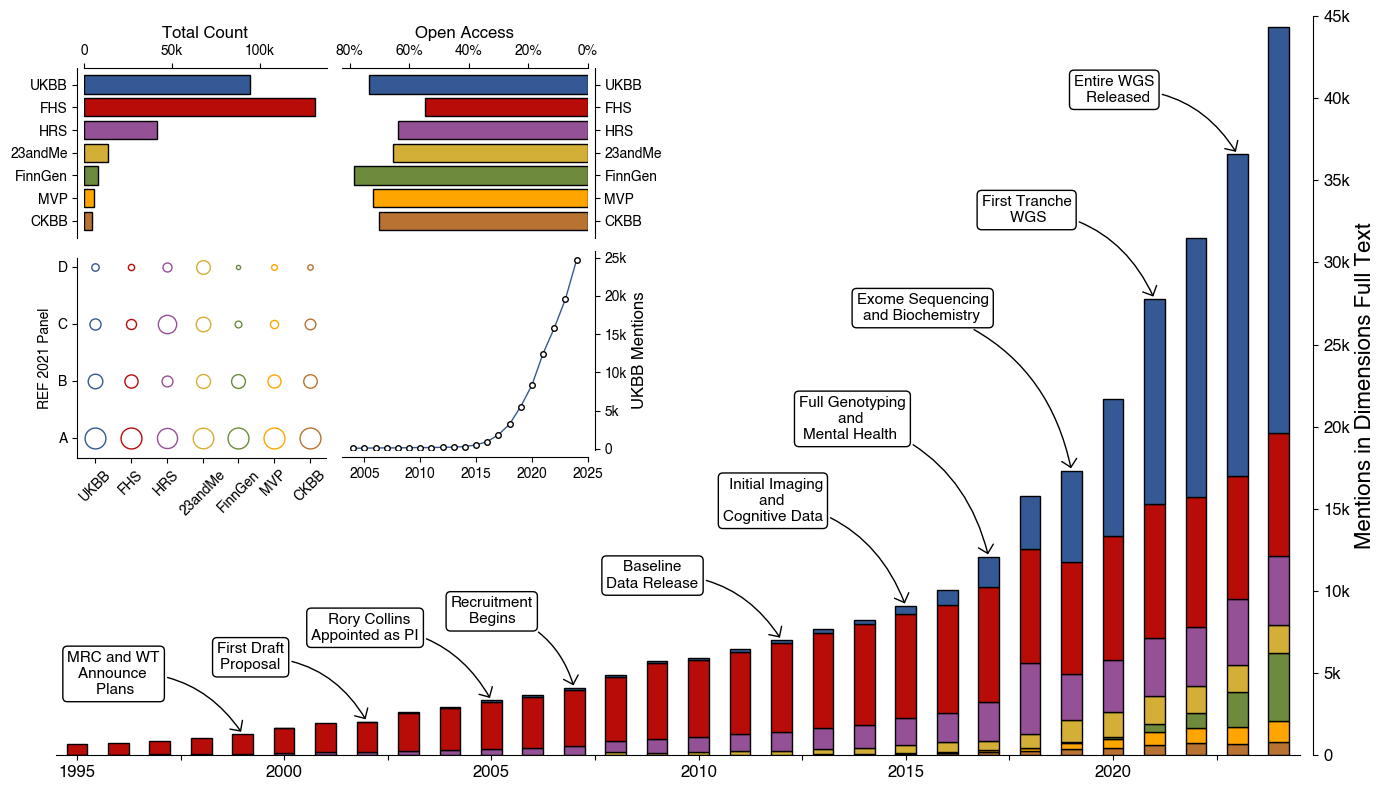

In [16]:
# === Custom Regal Color Palette ===
colors_dict = {

    "CKBB": "#B87333",      # Copper
    "MVP": "#FFA500",
    "FinnGen": "#6E8B3D",
    "23andMe": "#D4AF37",
    "HRS": "#955196",       # Antique Gold
    "FHS": "#B80C09",       # Royal Blue
    "UKBB": "#345995",      # Crimson Red

}

ordered_datasets = pd.Index(list(colors_dict.keys()))

plt.rcParams['font.family'] = 'Helvetica'

# === Aggregated Data for Main Plot ===
yearly_counts = df.groupby(['year', 'dataset']).size().unstack(fill_value=0)
dataset_totals = yearly_counts.sum(axis=0)
# Use fixed ordering for datasets:
top7_datasets = ordered_datasets
yearly_counts_top7 = yearly_counts[top7_datasets]
yearly_counts_top7_ordered = yearly_counts_top7[ordered_datasets]
yearly_counts_top7_ordered.columns = pd.Categorical(ordered_datasets, categories=ordered_datasets, ordered=True)
custom_colors = [colors_dict[ds] for ds in ordered_datasets]

# === Main Figure and Stacked Bar Plot ===
fig, ax = plt.subplots(figsize=(14, 8))
yearly_counts_top7_ordered.plot(kind='bar', stacked=True, ax=ax,
                                color=custom_colors, legend=False, edgecolor='k')
ax.set_axisbelow(False)
#ax.grid(True, axis='both', linestyle=(0, (2, 6)), linewidth=0.74, alpha=0.3, color='k', zorder=3)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Mentions in Dimensions Full Text', fontsize=16)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_major_locator(MaxNLocator(12))
sns.despine(ax=ax, left=True, top=True, right=False, bottom=False)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k' if x >= 1000 else f'{x:.0f}'))
for line in ax.get_xgridlines() + ax.get_ygridlines():
    line.set_zorder(10)

# === Inset Axes Setup ===
ax_inset1 = ax.inset_axes([0.0225, 0.7, 0.195, 0.23])   # Top-left: Total Count barh
ax_inset2 = ax.inset_axes([0.23, 0.7, 0.1975, 0.23])  # Top-right: Open Access % barh
ax_inset3 = ax.inset_axes([0.017, 0.4025, 0.2, 0.27])    # Bottom-left: Heatmap-style scatter plot (L2 %)
ax_inset4 = ax.inset_axes([0.23, 0.4125, 0.1975, 0.27])  # Bottom-right: UKBB yearly line plot
for ax_inset in [ax_inset1, ax_inset2, ax_inset3, ax_inset4]:
    ax_inset.set_zorder(0)
    ax_inset.patch.set_alpha(0)

# --- Inset 1: Horizontal Bar Chart of Total Counts ---
top7_totals_ordered = dataset_totals.reindex(ordered_datasets)
positions = range(len(top7_totals_ordered))
ax_inset1.barh(positions, top7_totals_ordered.values,
               color=[colors_dict[ds] for ds in ordered_datasets],
               edgecolor='k')
ax_inset1.set_xlabel('Total Count', fontsize=12)
ax_inset1.set_yticks(positions)
ax_inset1.set_yticklabels(list(ordered_datasets), fontsize=8)
ax_inset1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k' if x >= 1000 else f'{x:.0f}'))
# Move x-axis to top in inset1:
ax_inset1.xaxis.tick_top()
ax_inset1.xaxis.set_label_position('top')
ax_inset1.spines['top'].set_visible(True)
ax_inset1.spines['bottom'].set_visible(False)
ax_inset1.spines['left'].set_visible(True)
ax_inset1.spines['right'].set_visible(False)

# --- Inset 2: Barh Plot for Open Access % ---
def is_open(val):
    if isinstance(val, list):
        return 'closed' not in [str(item).lower() for item in val]
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list):
            return 'closed' not in [str(item).lower() for item in parsed]
    except Exception:
        pass
    return str(val).lower() != 'closed'
open_access_counts = df[df['open_access'].notna()].groupby('dataset')['open_access'].apply(lambda s: s.apply(is_open).sum())
open_access_counts = open_access_counts.reindex(ordered_datasets, fill_value=0)
totals = dataset_totals.reindex(ordered_datasets, fill_value=0)
open_access_percent = (open_access_counts / totals) * 100
positions = range(len(open_access_percent))
ax_inset2.barh(positions, open_access_percent.values,
               color=[colors_dict[ds] for ds in ordered_datasets], edgecolor='k')
ax_inset2.set_xlabel('Open Access', fontsize=12)
ax_inset2.set_yticks(positions)
ax_inset2.set_yticklabels(list(ordered_datasets), fontsize=8)
ax_inset2.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
ax_inset2.invert_xaxis()  # Bars extend from the right.
ax_inset2.yaxis.tick_right()
ax_inset2.yaxis.set_label_position("right")
ax_inset2.spines['top'].set_visible(True)
ax_inset2.spines['bottom'].set_visible(False)
ax_inset2.spines['left'].set_visible(False)
ax_inset2.spines['right'].set_visible(True)
# Move x-axis to top in inset2:
ax_inset2.xaxis.tick_top()
ax_inset2.xaxis.set_label_position('top')

# --- Inset 3: Heatmap-Style Scatter Plot for L2 % by Panel & Dataset ---
df_L2_filtered = df_L2[df_L2['L'] == 'L2']
df_L2_filtered = df_L2_filtered[df_L2_filtered['dataset'].isin(ordered_datasets)]
grouped = df_L2_filtered.groupby(['Panel', 'dataset']).size().reset_index(name='count')
total_by_dataset = df_L2_filtered.groupby('dataset').size().reset_index(name='total')
merged = pd.merge(grouped, total_by_dataset, on='dataset')
merged['percent'] = merged['count'] / merged['total'] * 100
panel_order = ['A', 'B', 'C', 'D']
merged['Panel'] = pd.Categorical(merged['Panel'], categories=panel_order, ordered=True)
ordered_datasets_list = list(ordered_datasets)
factor = 50  # scaling factor
for _, row in merged.iterrows():
    x_pos = len(ordered_datasets_list) - 1 - ordered_datasets_list.index(row['dataset'])
    y_pos = panel_order.index(row['Panel'])
    marker_size = factor * np.log1p(row['percent'])
    edge_color = colors_dict[row['dataset']] if row['dataset'] in colors_dict else 'black'
    ax_inset3.scatter(x_pos, y_pos, s=marker_size, edgecolor=edge_color, linewidth=1,
                      facecolor='white', alpha=1)
# Set x-ticks using reversed order.
ax_inset3.set_xticks(range(len(ordered_datasets_list)))
ax_inset3.set_xticklabels(list(reversed(ordered_datasets_list)), fontsize=10, rotation=45)
# Set y-tick labels to be the panel names.
ax_inset3.set_yticks(range(len(panel_order)))
ax_inset3.set_yticklabels(panel_order, fontsize=10)
ax_inset3.set_ylabel('REF 2021 Panel', fontsize=10)
ax_inset3.set_ylim(-.35, ax_inset3.get_ylim()[1])
ax_inset3.set_xlim(-.5, ax_inset3.get_xlim()[1]+.15)
ax_inset3.spines['top'].set_visible(False)
ax_inset3.spines['right'].set_visible(False)

# --- Inset 4: UKBB Yearly Count Line Graph with Scatter Markers ---
ukbb_counts = yearly_counts['UKBB']
ukbb_counts = ukbb_counts[ukbb_counts.index >= 2004]
ax_inset4.plot(ukbb_counts.index, ukbb_counts.values, 
               marker='o', markeredgecolor='k',
               markerfacecolor='w',
               color=colors_dict["UKBB"], linewidth=1, markersize=4)
ax_inset4.tick_params(axis='x', labelsize=8)
ax_inset4.tick_params(axis='y', labelsize=8)
ax_inset4.set_ylabel('UKBB Mentions', fontsize=12)
ax_inset4.yaxis.tick_right()
ax_inset4.yaxis.set_label_position("right")
ax_inset4.set_ylim(-200, ax_inset4.get_ylim()[1])
ax_inset4.spines['right'].set_position(('outward', 5))
ax_inset4.spines['bottom'].set_position(('outward', 5))
ax_inset4.xaxis.set_major_locator(MaxNLocator(5))
ax_inset4.spines['top'].set_visible(False)
ax_inset4.spines['left'].set_visible(False)
ax_inset4.yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda y, pos: f'{y/1000:.0f}k' if y >= 1000 else f'{y:.0f}'))

ax.spines['right'].set_position(('outward', 10))
ax_inset1.spines['left'].set_position(('outward', 5))
ax_inset1.spines['bottom'].set_position(('outward', 5))
ax_inset2.spines['right'].set_position(('outward', 5))
ax_inset2.spines['bottom'].set_position(('outward', 5))

for axx in [ax_inset1, ax_inset2, ax_inset3, ax_inset4]:
    axx.tick_params(axis='both', which='major', labelsize=10)

ax.set_ylim(ax.get_ylim()[0], 45000)

year_val = 2012
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Baseline    \nData Release",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +3000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2015
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Initial Imaging\nand         \nCognitive Data",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +5000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2017
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Full Genotyping\nand          \nMental Health  ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +7000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2019
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Exome Sequencing\nand Biochemistry  ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +9000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2021
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "First Tranche\nWGS      ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +4500),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2023
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Entire WGS\nReleased ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +3000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 1999
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "MRC and WT\nAnnounce   \nPlans      ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +2250),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2002
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "First Draft\nProposal ",
        xy=(idx, y_top),
        xytext=(idx - 2, y_top +3000),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2005
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Rory Collins  \nAppointed as PI",
        xy=(idx, y_top),
        xytext=(idx - 1.75, y_top +3500),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )

year_val = 2007
if year_val in yearly_counts_top7_ordered.index:
    idx = list(yearly_counts_top7_ordered.index).index(year_val)
    y_top = yearly_counts_top7_ordered.loc[year_val].sum()
    ax.annotate(
        "Recruitment\nBegins    ",
        xy=(idx, y_top),
        xytext=(idx - 1, y_top +3750),
        textcoords='data',
        ha='right',
        va='bottom',
        fontsize=11,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='k', lw=1),
        arrowprops=dict(
            arrowstyle='->,head_length=.5,head_width=.5',
            color='k',
            connectionstyle="arc3,rad=-0.3",
            lw=1
        )
    )


plt.tight_layout()
plt.savefig("../output/figures/full_text_search.pdf", bbox_inches='tight')
plt.savefig("../output/figures/full_text_search.svg", bbox_inches='tight')
plt.savefig("../output/figures/full_text_search.png", bbox_inches='tight', dpi=1200)

In [ ]:
ordered_datasets=['CKBB', 'ELSA', 'UKHLS', 'ALSPAC', 'HRS', 'FHS','UKBB']